# Preprocessing
*Written by Luke Chang*

Being able to study brain activity associated with cognitive processes in humans is an amazing achievement. However, as we have noted throughout this course, there is an extraordinary amount of noise and a very low levels of signal, which makes it difficult to make inferences about the function of the brain using this BOLD imaging. A critical step before we can perform any analyses is to do our best to remove as much of the noise as possible. The series of steps to remove noise comprise our *neuroimaging data **preprocessing** pipeline*. See slides on our preprocessing lecture {download}`here <../images/lectures/Preprocessing.pdf>`.

![preprocessing](https://dartbrains.org/_images/preprocessing.png)

In this lab, we will go over the basics of preprocessing fMRI data using the [fmriprep](https://fmriprep.readthedocs.io/en/stable/) preprocessing pipeline. We will cover:

 - Image transformations
 - Head motion correction
 - Spatial Normalization
 - Spatial Smoothing
 
There are other preprocessing steps that are also common, but not necessarily performed by all labs such as slice timing and distortion correction. We will not be discussing these in depth outside of the videos.

Let's start with watching a short video by Martin Lindquist to get a general overview of the main steps of preprocessing and the basics of how to transform images and register them to other images.

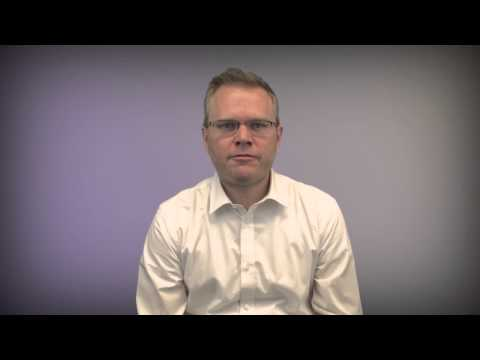

In [3]:
from IPython.display import YouTubeVideo

YouTubeVideo('Qc3rRaJWOc4')

## Image Transformations 

Ok, now let's dive deeper into how we can transform images into different spaces using linear transformations.

Recall from our introduction to neuroimaging data lab, that neuroimaging data is typically stored in a nifti container, which contains a 3D or 4D matrix of the voxel intensities and also an affine matrix, which provides instructions for how to transform the matrix into another space.

Let's create an interactive plot using ipywidgets so that we can get an intuition for how these affine matrices can be used to transform a 3D image.

We can move the sliders to play with applying rigid body  transforms to a 3D cube. A rigid body transformation has 6 parameters: translation in x,y, & z, and rotation around each of these axes. The key thing to remember is that a rigid body transform doesn't allow the image to be fundamentally changed. A full 12 parameter affine transformation adds an additional 3 parameters each for scaling and shearing, which can change the shape of the cube.

Try moving some of the sliders around. Note that the viewer is a little slow. Each time you move a slider it is applying an affine transformation to the matrix and re-plotting. 

Translation moves the cube in x, y, and z dimensions.

We can also rotate the cube around the x, y, and z axes where the origin is the center point. Continuing to rotate around the point will definitely lead to the cube leaving the current field of view, but it will come back if you keep rotating it.

You'll notice that every time we change the slider and apply a new affine transformation that the cube gets a little distorted with aliasing. Often we need to interpolate the image after applying a transformation to fill in the gaps after applying a transformation. It is important to keep in mind that every time we apply an affine transformation to our images, it is actually not a perfect representation of the original data. Additional steps like reslicing, interpolation, and spatial smoothing can help with this.

In [2]:
%matplotlib inline

from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
from nibabel.affines import apply_affine, from_matvec, to_matvec
from scipy.ndimage import affine_transform, map_coordinates
import nibabel as nib
from ipywidgets import interact, FloatSlider

def plot_rigid_body_transformation(trans_x=0, trans_y=0, trans_z=0, rot_x=0, rot_y=0, rot_z=0):
    '''This plot creates an interactive demo to illustrate the parameters of a rigid body transformation'''
    fov = 30
    radius = 10
    x, y, z = np.indices((fov, fov, fov))
    cube = ((x > fov//2 - radius//2) & (x < fov//2 + radius//2)) & ((y > fov//2 - radius//2) & (y < fov//2 + radius//2)) & ((z > fov//2 - radius//2) & (z < fov//2 + radius//2 ))
    cube = cube.astype(int)

    vec = np.array([trans_x, trans_y, trans_z])
    
    rot_x = np.radians(rot_x)
    rot_y = np.radians(rot_y)
    rot_z = np.radians(rot_z)
    rot_axis1 = np.array([[1, 0, 0],
                         [0, np.cos(rot_x), -np.sin(rot_x)],
                         [0, np.sin(rot_x), np.cos(rot_x)]])

    rot_axis2 = np.array([[np.cos(rot_y), 0, np.sin(rot_y)],
                         [0, 1, 0],
                         [-np.sin(rot_y), 0, np.cos(rot_y)]])

    rot_axis3 = np.array([[np.cos(rot_z), -np.sin(rot_z), 0],
                         [np.sin(rot_z), np.cos(rot_z), 0],
                         [0, 0, 1]])

    rotation = rot_axis1 @ rot_axis2 @ rot_axis3
    
    affine = from_matvec(rotation, vec)
    
    i_coords, j_coords, k_coords = np.meshgrid(range(cube.shape[0]), range(cube.shape[1]), range(cube.shape[2]), indexing='ij')
    coordinate_grid = np.array([i_coords, j_coords, k_coords])
    coords_last = coordinate_grid.transpose(1, 2, 3, 0)
    transformed = apply_affine(affine, coords_last)
    coords_first = transformed.transpose(3, 0, 1, 2)

    fig = plt.figure(figsize=(15, 12))
    ax = plt.axes(projection='3d')
    ax.voxels(map_coordinates(cube, coords_first))
    ax.set_xlabel('x', fontsize=16)
    ax.set_ylabel('y', fontsize=16)
    ax.set_zlabel('z', fontsize=16)

interact(plot_rigid_body_transformation, 
         trans_x=FloatSlider(value=0, min=-10, max=10, step=1),
         trans_y=FloatSlider(value=0, min=-10, max=10, step=1),
         trans_z=FloatSlider(value=0, min=-10, max=10, step=1),
         rot_x=FloatSlider(value=0, min=0, max=360, step=15),
         rot_y=FloatSlider(value=0, min=0, max=360, step=15),
         rot_z=FloatSlider(value=0, min=0, max=360, step=15))

interactive(children=(FloatSlider(value=0.0, description='trans_x', max=10.0, min=-10.0, step=1.0), FloatSlide…

<function __main__.plot_rigid_body_transformation(trans_x=0, trans_y=0, trans_z=0, rot_x=0, rot_y=0, rot_z=0)>

![rigidbody](https://dartbrains.org/_images/Rigid_Body.gif)

Ok, so what's going on behind the sliders?

Let's borrow some of the material available in the nibabel [documentation](https://nipy.org/nibabel/coordinate_systems.html) to understand how these transformations work.

The affine matrix is a way to transform images between spaces. In general, we have some voxel space coordinate $(i, j, k)$, and we want to figure out how to remap this into a reference space coordinate $(x, y, z)$.

It can be useful to think of this as a coordinate transform function $f$ that accepts a voxel coordinate in the original space as an *input* and returns a coordinate in the *output* reference space:

$$(x, y, z) = f(i, j, k)$$

In theory $f$ could be a complicated non-linear function, but in practice we typically assume that the relationship between $(i, j, k)$ and $(x, y, z)$ is linear (or *affine*), and can be encoded with linear affine transformations comprising translations, rotations, and zooms.

Scaling (zooming) in three dimensions can be represented by a diagonal 3 by 3
matrix.  Here's how to zoom the first dimension by $p$, the second by $q$ and
the third by $r$ units:

$$
\begin{bmatrix}
x\\
y\\
z
\end{bmatrix} 
\quad
=
\quad
\begin{bmatrix}
p & i\\
q & j\\
r & k
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
p & 0 & 0 \\
0 & q & 0 \\
0 & 0 & r
\end{bmatrix}
\quad
\begin{bmatrix}
i\\
j\\
k
\end{bmatrix}
$$

A rotation in three dimensions can be represented as a 3 by 3 *rotation matrix* [wikipedia rotation matrix](https://en.wikipedia.org/wiki/Rotation_matrix). For example, here is a rotation by $\theta$ radians around the third array axis:

$$
\begin{bmatrix}
x \\
y \\
z
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
\cos(\theta) &  -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1 \\
\end{bmatrix}
\quad
\begin{bmatrix}
i \\
j \\
k
\end{bmatrix}
$$

This is a rotation by $\phi$ radians around the second array axis:

$$
\begin{bmatrix}
x \\
y \\
z \\
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
\cos(\phi) & 0 & \sin(\phi) \\
0 & 1 & 0 \\
-\sin(\phi) & 0 & \cos(\phi) \\
\end{bmatrix}
\quad
\begin{bmatrix}
i \\
j \\
k 
\end{bmatrix}
$$

A rotation of $\gamma$ radians around the first array axis:

$$
\begin{bmatrix}
x\\
y\\
z
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
1 & 0 & 0 \\
0 & \cos(\gamma) & -\sin(\gamma) \\
0 & \sin(\gamma) & \cos(\gamma) \\
\end{bmatrix}
\quad
\begin{bmatrix}
i \\
j \\
k
\end{bmatrix}
$$

Zoom and rotation matrices can be combined by matrix multiplication.

Here's a scaling of $p, q, r$ units followed by a rotation of $\theta$ radians
around the third axis followed by a rotation of $\phi$ radians around the
second axis:

$$
\begin{bmatrix}
x \\
y \\
z
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
\cos(\phi) & 0 & \sin(\phi) \\
0 & 1 & 0 \\
-\sin(\phi) & 0 & \cos(\phi) \\
\end{bmatrix}
\quad
\begin{bmatrix}
\cos(\theta) &  -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1 \\
\end{bmatrix}
\quad
\begin{bmatrix}
p & 0 & 0 \\
0 & q & 0 \\
0 & 0 & r \\
\end{bmatrix}
\quad
\begin{bmatrix}
i\\
j\\
k\\
\end{bmatrix}
$$

This can also be written:


$$
M
\quad
=
\quad
\begin{bmatrix}
\cos(\phi) & 0 & \sin(\phi) \\
0 & 1 & 0 \\
-\sin(\phi) & 0 & \cos(\phi) \\
\end{bmatrix}
\quad
\begin{bmatrix}
\cos(\theta) &  -\sin(\theta) & 0 \\
\sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 1 \\
\end{bmatrix}
\quad
\begin{bmatrix}
p & 0 & 0 \\
0 & q & 0 \\
0 & 0 & r \\
\end{bmatrix}
$$

$$
\begin{bmatrix}
x \\
y \\
z 
\end{bmatrix}
\quad
=
\quad
M
\quad
\begin{bmatrix}
i \\
j \\
k
\end{bmatrix}
$$

This might be obvious because the matrix multiplication is the result of
applying each transformation in turn on the coordinates output from the
previous transformation. Combining the transformations into a single matrix
$M$ works because matrix multiplication is associative -- $ABCD = (ABC)D$.

A translation in three dimensions can be represented as a length 3 vector to
be added to the length 3 coordinate.  For example, a translation of $a$ units
on the first axis, $b$ on the second and $c$ on the third might be written
as:

$$
\begin{bmatrix}
x \\
y \\
z
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
i \\
j \\
k
\end{bmatrix}
\quad
+
\quad
\begin{bmatrix}
a \\
b \\
c 
\end{bmatrix}
$$

We can write our function $f$ as a combination of matrix multiplication by some 3 by 3 rotation / zoom matrix $M$ followed by addition of a 3 by 1 translation vector $(a, b, c)$

$$
\begin{bmatrix}
x \\
y \\
z
\end{bmatrix}
\quad
=
\quad
M
\quad
\begin{bmatrix}
i \\
j \\
k
\end{bmatrix}
\quad
+
\quad
\begin{bmatrix}
a \\
b \\
c
\end{bmatrix}
$$

We could record the parameters necessary for $f$ as the 3 by 3 matrix, $M$
and the 3 by 1 vector $(a, b, c)$.

In fact, the 4 by 4 image *affine array* includes this exact information. If $m_{i,j}$ is the value in row $i$ column $j$ of matrix $M$, then the image affine matrix $A$ is:

$$
A
\quad
=
\quad
\begin{bmatrix}
m_{1,1} & m_{1,2} & m_{1,3} & a \\
m_{2,1} & m_{2,2} & m_{2,3} & b \\
m_{3,1} & m_{3,2} & m_{3,3} & c \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
$$

Why the extra row of $[0, 0, 0, 1]$?  We need this row because we have rephrased the combination of rotations / zooms and translations as a transformation in *homogenous coordinates* (see [wikipedia homogenous
coordinates](https://en.wikipedia.org/wiki/Homogeneous_coordinates)). This is a trick that allows us to put the translation part into the same matrix as the rotations / zooms, so that both translations and rotations / zooms can be applied by matrix multiplication. In order to make this work, we have to add an extra 1 to our input and output coordinate vectors:

$$
\begin{bmatrix}
x \\
y \\
z \\
1
\end{bmatrix}
\quad
=
\quad
\begin{bmatrix}
m_{1,1} & m_{1,2} & m_{1,3} & a \\
m_{2,1} & m_{2,2} & m_{2,3} & b \\
m_{3,1} & m_{3,2} & m_{3,3} & c \\
0 & 0 & 0 & 1 \\
\end{bmatrix}
\quad
\begin{bmatrix}
i \\
j \\
k \\
1
\end{bmatrix}
$$

This results in the same transformation as applying $M$ and $(a, b, c)$ separately. One advantage of encoding transformations this way is that we can combine two sets of rotations, zooms, translations by matrix multiplication of the two corresponding affine matrices.

In practice, although it is common to combine 3D transformations using 4 x 4 affine matrices, we usually *apply* the transformations by breaking up the affine matrix into its component $M$ matrix and $(a, b, c)$ vector and doing:

$$
\begin{bmatrix}
x \\
y \\
z
\end{bmatrix}
\quad
=
\quad
M
\quad
\begin{bmatrix}
i \\
j \\
k
\end{bmatrix}
\quad
+
\quad
\begin{bmatrix}
a \\
b \\
c
\end{bmatrix}
$$

As long as the last row of the 4 by 4 is $[0, 0, 0, 1]$, applying the transformations in this way is mathematically the same as using the full 4 by 4 form, without the inconvenience of adding the extra 1 to our input and output vectors.

You can think of the image affine as a combination of a series of transformations to go from voxel coordinates to mm coordinates in terms of the magnet isocenter. Here is the EPI affine broken down into a series of transformations, with the results shown on the localizer image:

<img src="https://nipy.org/nibabel/_images/illustrating_affine.png" />

Applying different affine transformations allows us to rotate, reflect, scale, and shear the image.

## Cost Functions
Now that we have learned how affine transformations can be applied to transform images into different spaces, how can we use this to register one brain image to another image?

The key is to identify a way to quantify how aligned the two images are to each other. Our visual systems are very good at identifying when two images are aligned, however, we need to create an alignment measure. These measures are often called *cost functions*. 

There are many different types of cost functions depending on the types of images that are being aligned. For example, a common cost function is called minimizing the sum of the squared differences and is similar to how regression lines are fit to minimize deviations from the observed data. This measure works best if the images are of the same type and have roughly equivalent signal intensities.

Let's create another interactive plot and find the optimal X & Y translation parameters that minimize the difference between a two-dimensional target image to a reference image.

In [4]:
from copy import deepcopy

def plot_affine_cost(trans_x=0, trans_y=0):
    '''This function creates an interactive demo to highlight how a cost function works in image registration.'''
    fov = 30
    radius = 15
    x, y = np.indices((fov, fov))
    square1 = (x < radius-2) & (y < radius-2)
    square2 = ((x > fov//2 - radius//2) & (x < fov//2 + radius//2)) & ((y > fov//2 - radius//2) & (y < fov//2 + radius//2))
    square1 = square1.astype(float)
    square2 = square2.astype(float)

    vec = np.array([trans_y, trans_x])
    
    affine = from_matvec(np.eye(2), vec)
    
    i_coords, j_coords = np.meshgrid(range(square1.shape[0]), range(square1.shape[1]), indexing='ij')
    coordinate_grid = np.array([i_coords, j_coords])
    coords_last = coordinate_grid.transpose(1, 2, 0)
    transformed = apply_affine(affine, coords_last)
    coords_first = transformed.transpose(2, 0, 1)
    
    transformed_square = map_coordinates(square1, coords_first)
    f,a = plt.subplots(ncols=3, figsize=(15, 5))
    a[0].imshow(transformed_square)
    a[0].set_xlabel('x', fontsize=16)
    a[0].set_ylabel('y', fontsize=16)
    a[0].set_title('Target Image', fontsize=18)
    
    a[1].imshow(square2)
    a[1].set_xlabel('x', fontsize=16)
    a[1].set_ylabel('y', fontsize=16)
    a[1].set_title('Reference Image', fontsize=18)
    
    point_x = deepcopy(trans_x)
    point_y = deepcopy(trans_y)
    sse = np.sum((transformed_square - square2)**2)
    a[2].bar(0, sse)
    a[2].set_ylim([0, 350])
    a[2].set_ylabel('SSE', fontsize=18)
    a[2].set_xlabel('Cost Function', fontsize=18)
    a[2].set_xticks([])
    a[2].set_title(f'Parameters: ({int(trans_x)},{int(trans_y)})', fontsize=20)
    plt.tight_layout()
    
interact(plot_affine_cost, 
         trans_x=FloatSlider(value=0, min=-30, max=0, step=1),
         trans_y=FloatSlider(value=0, min=-30, max=0, step=1))

interactive(children=(FloatSlider(value=0.0, description='trans_x', max=0.0, min=-30.0, step=1.0), FloatSlider…

<function __main__.plot_affine_cost(trans_x=0, trans_y=0)>

![costfunction](https://dartbrains.org/_images/Cost_Function.gif)

You probably had to move the sliders around back and forth until you were able to reduce the sum of squared error to zero. This cost function increases exponentially the further you are away from your target. The process of minimizing (or sometimes maximizing) cost functions to identify the best fitting parameters is called *optimization* and is a concept that is core to fitting models to data across many different disciplines.

| Cost Function | Use Case | Example |
|:---:|:---:|:---:|
| Sum of Squared Error | Images of same modality and scaling | Two T2* images  |
| Normalized correlation | Images of same modality | two T1 images   |
| Correlation ratio | Any modality  | T1 and FLAIR   |
| Mutual information or normalized mutual information | Any modality  | T1 and CT |
| Boundary Based Registration  | Images with some contrast across boundaries of interest | EPI and T1 |



## Realignment

Now let's put everything we learned together to understand how we can correct for head motion in functional images that occurred during a scanning session. It is extremely important to make sure that a specific voxel has the same 3D coordinate across all time points to be able to model neural processes. This of course is made difficult by the fact that participants move during a scanning session and also in between runs. 

Realignment is the preprocessing step in which a rigid body transformation is applied to each volume to align them to a common space. One typically needs to choose a reference volume, which might be the first, middle, or last volume, or the mean of all volumes.

Let's look at an example of the translation and rotation parameters after running realignment on our first subject.

Text(0.5, 1.0, 'Rotation')

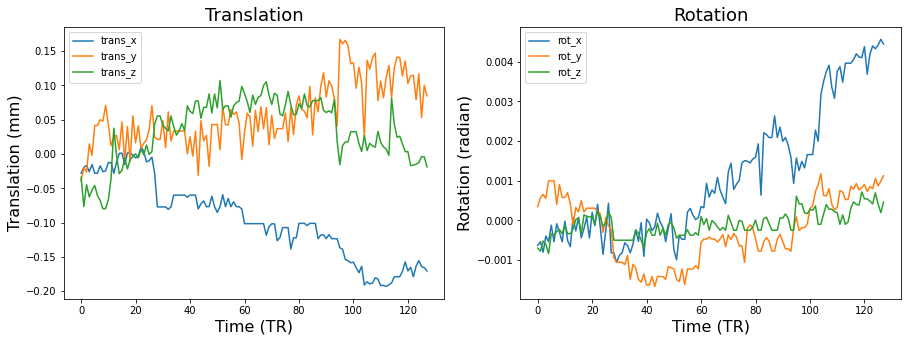

In [643]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from bids import BIDSLayout, BIDSValidator
import os

data_dir = '../data/localizer'
layout = BIDSLayout(data_dir, derivatives=True)

data = pd.read_csv(layout.get(subject='S01', scope='derivatives', extension='.tsv')[0].path, sep='\t')

f,a = plt.subplots(ncols=2, figsize=(15,5))

data.loc[:,['trans_x','trans_y','trans_z']].plot(ax=a[0])
a[0].set_ylabel('Translation (mm)', fontsize=16)
a[0].set_xlabel('Time (TR)', fontsize=16)
a[0].set_title('Translation', fontsize=18)

data.loc[:,['rot_x','rot_y','rot_z']].plot(ax=a[1])
a[1].set_ylabel('Rotation (radian)', fontsize=16)
a[1].set_xlabel('Time (TR)', fontsize=16)
a[1].set_title('Rotation', fontsize=18)

Don't forget that even though we can approximately put each volume into a similar position with realignment that head motion always distorts the magnetic field and can lead to nonlinear changes in signal intensity that will not be addressed by this procedure. In the resting-state literature, where many analyses are based on functional connectivity, head motion can lead to spurious correlations. Some researchers choose to exclude any subject that moved more than certain amount. Other's choose to remove the impact of these time points in their data through removing the volumes via *scrubbing* or modeling out the volume with a dummy code in the first level general linear models.

## Spatial Normalization
There are several other preprocessing steps that involve image registration. The main one is called *spatial normalization*, in which each subject's brain data is warped into a common stereotactic space. Talaraich is an older space, that has been subsumed by various standards developed by the Montreal Neurological Institute.

There are a variety of algorithms to warp subject data into stereotactic space. Linear 12 parameter affine transformation have been increasingly been replaced by more complicated nonlinear normalizations that have hundreds to thousands of parameters. 

One nonlinear algorithm that has performed very well across comparison studies is *diffeomorphic registration*, which can also be inverted so that subject space can be transformed into stereotactic space and back to subject space. This is the core of the [ANTs](http://stnava.github.io/ANTs/) algorithm that is implemented in fmriprep. See this [overview](https://elef.soic.indiana.edu/documentation/0.15.0.dev/examples_built/syn_registration_2d/) for more details.

Let's watch another short video by Martin Lindquist and Tor Wager to learn more about the core preprocessing steps.

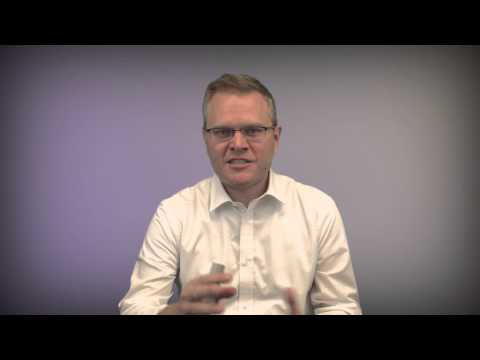

In [4]:
YouTubeVideo('qamRGWSC-6g')

There are many different steps involved in the spatial normalization process and these details vary widely across various imaging software packages. We will briefly discuss some of the steps involved in the anatomical preprocessing pipeline implemented by fMRIprep and will be showing example figures from the output generated by the pipeline.

First, brains are extracted from the skull and surrounding dura mater. You can check and see how well the algorithm performed by examining the red outline.

![normalization](https://dartbrains.org/_images/T1_normalization.png)

Next, the anatomical images are segmented into different tissue types, these tissue maps are used for various types of analyses, including providing a grey matter mask to reduce the computational time in estimating statistics. In addition, they provide masks to aid in extracting average activity in CSF, or white matter, which might be used as covariates in the statistical analyses to account for physiological noise.
![normalization](https://dartbrains.org/_images/T1_segmentation.png)

### Spatial normalization of the anatomical T1w reference
fmriprep uses the [ANTs](http://stnava.github.io/ANTs/) to perform nonlinear spatial normaliziation. It is easy to check to see how well the algorithm performed by viewing the results of aligning the T1w reference to the stereotactic reference space. Hover on the panels with the mouse pointer to transition between both spaces. We are using the MNI152NLin2009cAsym template.
![normalization](https://dartbrains.org/_images/sub-S01_space-MNI152NLin2009cAsym_T1w.svg)

### Alignment of functional and anatomical MRI data
Next, we can evaluate the quality of alignment of the functional data to the anatomical T1 image. FSL `flirt` was used to generate transformations from EPI-space to T1w-space - The white matter mask calculated with FSL `fast` (brain tissue segmentation) was used for BBR. Note that Nearest Neighbor interpolation is used in the reportlets in order to highlight potential spin-history and other artifacts, whereas final images are resampled using Lanczos interpolation. Notice these images are much blurrier and show some distortion compared to the T1s. 
![epi](https://dartbrains.org/_images/sub-S01_task-localizer_desc-flirtbbr_bold.svg)

## Spatial Smoothing
The last step we will cover in the preprocessing pipeline is *spatial smoothing*. This step involves applying a filter to the image, which removes high frequency spatial information. This step is identical to convolving a kernel to a 1-D signal that we covered in the {doc}`../content/Signal_Processing` lab, but the kernel here is a 3-D Gaussian kernel. The amount of smoothing is determined by specifying the width of the distribution (i.e., the standard deviation) using the Full Width at Half Maximum (FWHM) parameter.

Why we would want to decrease our image resolution with spatial smoothing after we tried very hard to increase our resolution at the data acquisition stage? This is because this step may help increase the signal to noise ratio by reducing the impact of partial volume effects, residual anatomical differences following normalization, and other aliasing from applying spatial transformation.

Here is what a 3D gaussian kernel looks like.

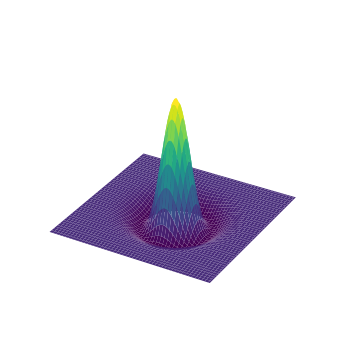

In [5]:
def plot_gaussian(sigma=2, kind='surface', cmap='viridis', linewidth=1, **kwargs):
    '''Generates a 3D matplotlib plot of a Gaussian distribution'''
    mean=0
    domain=10
    x = np.arange(-domain + mean, domain + mean, sigma/10)
    y = np.arange(-domain + mean, domain + mean, sigma/10)
    x, y = np.meshgrid(x, x)
    r = (x ** 2 + y ** 2) / (2 * sigma ** 2)
    z = 1 / (np.pi * sigma ** 4) * (1 - r) * np.exp(-r)

    fig = plt.figure(figsize=(12, 6))

    ax = plt.axes(projection='3d')
    if kind=='wire':
        ax.plot_wireframe(x, y, z, cmap=cmap, linewidth=linewidth, **kwargs)
    elif kind=='surface':
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=linewidth, **kwargs)
    else:
        NotImplemented
    
    ax.set_xlabel('x', fontsize=16)
    ax.set_ylabel('y', fontsize=16)
    ax.set_zlabel('z', fontsize=16)
    plt.axis('off')

plot_gaussian(kind='surface', linewidth=1)


## fmriprep
Throughout this lab and course, you have frequently heard about [fmriprep](https://fmriprep.readthedocs.io/en/stable/), which is a functional magnetic resonance imaging (fMRI) data preprocessing pipeline that was developed by a team at the [Center for Reproducible Research](http://reproducibility.stanford.edu/) led by Russ Poldrack and Chris Gorgolewski. Fmriprep was designed to provide an easily accessible, state-of-the-art interface that is robust to variations in scan acquisition protocols, requires minimal user input, and provides easily interpretable and comprehensive error and output reporting. Fmriprep performs basic processing steps (coregistration, normalization, unwarping, noise component extraction, segmentation, skullstripping etc.) providing outputs that are ready for data analysis. 

fmriprep was built on top of [nipype](https://nipype.readthedocs.io/en/latest/), which is a tool to build preprocessing pipelines in python using graphs. This provides a completely flexible way to create custom pipelines using any type of software while also facilitating easy parallelization of steps across the pipeline on high performance computing platforms. Nipype is completely flexible, but has a fairly steep learning curve and is best for researchers who have strong opinions about how they want to preprocess their data, or are working with nonstandard data that might require adjusting the preprocessing steps or parameters. In practice, most researchers typically use similar preprocessing steps and do not need to tweak the pipelines very often. In addition, many researchers do not fully understand how each preprocessing step will impact their results and would prefer if somebody else picked suitable defaults based on current best practices in the literature. The fmriprep pipeline uses a combination of tools from well-known software packages, including FSL_, ANTs_, FreeSurfer_ and AFNI_. This pipeline was designed to provide the best software implementation for each state of preprocessing, and is quickly being updated as methods evolve and bugs are discovered by a growing user base.

This tool allows you to easily do the following:

- Take fMRI data from raw to fully preprocessed form.
- Implement tools from different software packages.
- Achieve optimal data processing quality by using the best tools available.
- Generate preprocessing quality reports, with which the user can easily identify outliers.
- Receive verbose output concerning the stage of preprocessing for each subject, including meaningful errors.
- Automate and parallelize processing steps, which provides a significant speed-up from typical linear, manual processing.
- More information and documentation can be found at https://fmriprep.readthedocs.io/


![image.png](https://dartbrains.org/_images/fmriprep.png)

### Running fmriprep
Running fmriprep is a (mostly) trivial process of running a single line in the command line specifying a few choices and locations for the output data. One of the annoying things about older neuroimaging software that was developed by academics is that the packages were developed using many different development environments and on different operating systems (e.g., unix, windows, mac). It can be a nightmare getting some of these packages to install on more modern computing systems. As fmriprep uses many different packages, they have made it much easier to circumvent the time-consuming process of installing many different packages by releasing a [docker container](https://fmriprep.readthedocs.io/en/stable/docker.html) that contains everything you need to run the pipeline.

Unfortunately, our AWS cloud instances running our jupyter server are not equipped with enough computational resources to run fmriprep at this time. However, if you're interested in running this on your local computer, here is the code you could use to run it in a jupyter notebook, or even better in the command line on a high performance computing environment.

```
import os
base_dir = '/Users/lukechang/Dropbox/Dartbrains/Data'
data_path = os.path.join(base_dir, 'localizer')
output_path = os.path.join(base_dir, 'preproc')
work_path = os.path.join(base_dir, 'work')

sub = 'S01'
subs = [f'S{x:0>2d}' for x in range(10)]
for sub in subs:
    !fmriprep-docker {data_path} {output_path} participant --participant_label sub-{sub} --write-graph --fs-no-reconall --notrack --fs-license-file ~/Dropbox/Dartbrains/License/license.txt --work-dir {work_path}
```

### Quick primer on High Performance Computing

We could run fmriprep on our computer, but this could take a long time if we have a lot of participants. Because we have a limited amount of computational resources on our laptops (e.g., cpus, and memory), we would have to run each participant sequentially. For example, if we had 50 participants, it would take 50 times longer to run all participants than a single one. 

Imagine if you had 50 computers and ran each participant separate at the same time in parallel across all of the computers. This would allow us to run 50 participants in the same amount of time as a single participant. This is the basic idea behind high performance computing, which contains a cluster of many computers that have been installed in racks. Below is a picture of what Dartmouth's [Discovery cluster](https://rc.dartmouth.edu/index.php/discovery-overview/) looks like:

![discovery](https://dartbrains.org/_images/hpc.png)

A cluster is simply a collection of nodes. A node can be thought of as an individual computer. Each node contains processors, which encompass multiple cores. Discovery contains 3000+ cores, which is certainly a lot more than your laptop!

In order to submit a job, you can create a Portable Batch System (PBS) script that sets up the parameters (e.g., how much time you want your script to run, specifying directory to run, etc) and submits your job to a queue.

**NOTE**: For this class, we will only be using the jupyterhub server, but if you end up working in a lab in the future, you will need to request access to the *discovery* system using this [link](https://rcweb.dartmouth.edu/accounts/).

### fmriprep output
You can see a summary of the operations fmriprep performed by examining the .html files in the `derivatives/fmriprep` folder within the `localizer` data directory.

We will load the first subject's output file. Spend some time looking at the outputs and feel free to examine other subjects as well. Currently, the first 10 subjects should be available on the jupyterhub.

In [621]:
from IPython.display import HTML

HTML('sub-S01.html')

## Limitations of fmriprep
In general, we recommend using this pipeline if you want a sensible default. Considerable thought has gone into selecting reasonable default parameters and selecting preprocessing steps based on best practices in the field (as determined by the developers). This is not necessarily the case for any of the default settings in any of the more conventional software packages (e.g., spm, fsl, afni, etc). 

However, there is an important tradeoff in using this tool. On the one hand, it's nice in that it is incredibly straightforward to use (one line of code!), has excellent documentation, and is actively being developed to fix bugs and improve the overall functionality. There is also a growing user base to ask questions.  [Neurostars](https://neurostars.org/) is an excellent forum to post questions and learn from others. On the other hand, fmriprep, is unfortunately in its current state not easily customizable. If you disagree with the developers about the order or specific preprocessing steps, it is very difficult to modify. Future versions will hopefully be more modular and easier to make custom pipelines.  If you need this type of customizability we strongly recommend using nipype over fmriprep.

In practice, it's alway a little bit finicky to get everything set up on a particular system. Sometimes you might run into issues with a specific missing file like the [freesurfer license](https://fmriprep.readthedocs.io/en/stable/usage.html#the-freesurfer-license) even if you're not using it. You might also run into issues with the format of the data that might have some conflicts with the [bids-validator](https://github.com/bids-standard/bids-validator). In our experience, there is always some frustrations getting this to work, but it's very nice once it's done.

## Exercises

### Exercise 1. Inspect HTML output of other participants.
For this exercise, you will need to navigate to the derivatives folder containing the fmriprep preprocessed data `../data/data/localizer/derivatives/fmriprep` and inspect the html output of other subjects (ie., not 'S01'). Did the preprocessing steps works? are there any issues with the data that we should be concerned about?
